In [76]:

# importing the necessary packages
import os
import cv2
import time
import torch
import zipfile
import numpy as np
import torch.nn as nn
import albumentations as A
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.models as models
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import GridSearchCV

In [77]:
#Extracting Data
from zipfile import ZipFile
file_name = 'Cam101.zip'
with ZipFile(file_name,'r') as zip:
  zip.extractall()

In [78]:
#Splitting Train and Test data
train_path = 'Cam101/train'
test_path = 'Cam101/test'

train_image = os.listdir(train_path)
test_image = os.listdir(test_path)
train_img_numbers = []
test_img_numbers = []
mas_train_img =[]
train_pics =[]
mas_test_img =[]
test_pics =[]
# Getting all .png filenames
for i,filename in enumerate(train_image):
    if filename.endswith("L.png"):
        train_img_numbers.append(filename)
        mas_train_img.append(train_image[i])
    else:
      train_pics.append(train_image[i])
for i,filename in enumerate(test_image):
    if filename.endswith("L.png"):
        test_img_numbers.append(filename)
        mas_test_img.append(test_image[i])
    else:
      test_pics.append(test_image[i])

print(f"There are {len(train_img_numbers)} train images and {len(test_img_numbers)} test images.")

There are 90 train images and 11 test images.


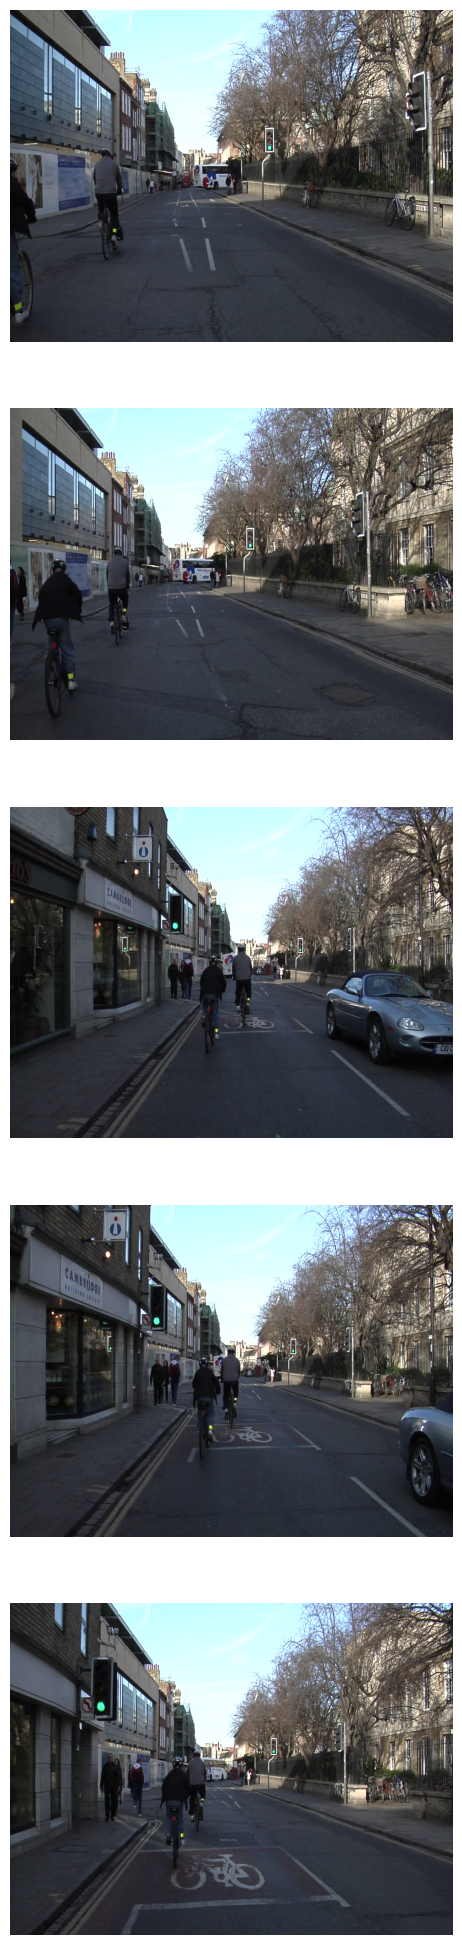

In [79]:
# Plotting some figures to visualize some samples

fig, ax = plt.subplots(5, 1, figsize=(25, 25))
for i in range(5):
    img = plt.imread(os.path.join(train_path, train_pics[i]))
    ax[i].imshow(img)
    ax[i].axis('off')
plt.show()

In [80]:
#Mapping
data_label = 'Cam101'
label_file = os.path.join(data_label, 'label_colors.txt')

mapping = {}
index_val = 0
with open(label_file, 'r') as f:
    for line in f:
        r, g, b, class_name = line.strip().split()
        rgb = (int(r), int(g), int(b))
        mapping[rgb] = index_val
        index_val += 1
mapping

{(64, 128, 64): 0,
 (192, 0, 128): 1,
 (0, 128, 192): 2,
 (0, 128, 64): 3,
 (128, 0, 0): 4,
 (64, 0, 128): 5,
 (64, 0, 192): 6,
 (192, 128, 64): 7,
 (192, 192, 128): 8,
 (64, 64, 128): 9,
 (128, 0, 192): 10,
 (192, 0, 64): 11,
 (128, 128, 64): 12,
 (192, 0, 192): 13,
 (128, 64, 64): 14,
 (64, 192, 128): 15,
 (64, 64, 0): 16,
 (128, 64, 128): 17,
 (128, 128, 192): 18,
 (0, 0, 192): 19,
 (192, 128, 128): 20,
 (128, 128, 128): 21,
 (64, 128, 192): 22,
 (0, 0, 64): 23,
 (0, 64, 64): 24,
 (192, 64, 128): 25,
 (128, 128, 0): 26,
 (192, 128, 192): 27,
 (64, 0, 64): 28,
 (192, 192, 0): 29,
 (0, 0, 0): 30,
 (64, 192, 0): 31}

In [81]:
# Define the augmentation transformations

aug = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

In [82]:
# Creating custom dataset to use in data loader

class LoadingData(Dataset):
    def __init__(self, folder, file_list, mapping):
        self.folder = folder
        self.file_list = file_list
        self.mapping = mapping

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        filename = self.file_list[idx]
        image_path = os.path.join(self.folder, filename)
        data_label = os.path.join(self.folder, filename.replace(".png", "_L.png"))
        image = cv2.imread(image_path)
        label = cv2.imread(data_label)

        # Converting labels to class indices
        index_class = np.zeros_like(label[..., 0])
        for class_color, class_index in self.mapping.items():
            # Creating a boolean mask where pixels match the current class color          
            mask = np.logical_and(label[:, :, 0] == class_color[0], np.logical_and(label[:, :, 1] == class_color[1], label[:, :, 2] == class_color[2]))
            index_class[mask] = class_index

        # Applying data augmentation
        augmented = aug(image=image, mask=index_class)
        image_aug = augmented['image']
        index_class_aug = augmented['mask']

        return image_aug, index_class_aug

# Paths to the training and testing data

train_folder = "Cam101/train"
test_folder = "Cam101/test"

# File names of the training and testing data

train_file_list = sorted([f for f in os.listdir(train_folder) if f.endswith('.png') and '_L' not in f])
test_file_list = sorted([f for f in os.listdir(test_folder) if f.endswith('.png') and '_L' not in f])


# Create custom datasets
train_dataset = LoadingData(train_folder, train_file_list, mapping)
test_dataset = LoadingData(test_folder, test_file_list, mapping)
# Splitting training dataset into training and val sets with a ratio of 90:10
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])


# Creating data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
val_loader = DataLoader(val_dataset, 1)

FCN16 Model

In [83]:
# Fully Convolutional Network 16 Model creation

class FCN16(nn.Module):
    def __init__(self, num_classes):
        super(FCN16, self).__init__()
        # Pre-trained ResNet101 model and freezing its parameters
        resnet = models.resnet101(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad = False
            
        # Fully Connected and average pooling Layer is removed
        modules = list(resnet.children())[:-2]
        self.base = nn.Sequential(*modules)

        #  Layers to add non linearity and normalization to remove overfitting
        self.conv = nn.Conv2d(2048, 512, kernel_size=2, stride=1, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(512)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(p=0.5)
        self.score_fr = nn.Conv2d(512, num_classes, kernel_size=1)
        self.upscore = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=32, stride=16, bias=False)

        # Weights initialization
        self._init_weights(num_classes)

        # Unfreezing the last two layers of the base model
        for module in self.base[-1][-2:]:
            for param in module.parameters():
                param.requires_grad = True

    def forward(self, x):
        # Applying forward to extract features from the base model
        x = self.base(x)
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.score_fr(x)
        x = self.upscore(x)
        return x

    def _init_weights(self, num_classes):
        # Initializing  weights of the deconvolutional layer to bilinear upsampling
        bi_linear = self._get_upsampling_weight(num_classes, num_classes, 32)
        self.upscore.weight.data.copy_(bi_linear)

    def _get_upsampling_weight(self, in_channels, out_channels, kernel_size):
        # Creating bilinear kernel for upsampling
        fac = (kernel_size + 1) // 2
        cen = kernel_size / 2
        # Computing the bilinear weights for each pixel location in the filter.
        weight = torch.zeros((in_channels, out_channels, kernel_size, kernel_size), dtype=torch.float32)
        for i in range(kernel_size):
            for j in range(kernel_size):
                weight[:, :, i, j] = (1 - abs(i - cen) / fac) * (1 - abs(j - cen) / fac)
        return weight

In [84]:
# Creating function to Train the model
def train(model, train_loader, optimizer, criterion, num_epochs):
    r_losses = []
    for epoch in range(num_epochs):
        run_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            # Resizing the output predictions to match the size of the target labels
            outputs = F.interpolate(outputs, size=labels.shape[-2:], mode='bilinear', align_corners=True)
            # Converting the target labels to long tensor data type
            labels = labels.to(torch.long)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            run_loss += loss.item()
            # Print the loss every 10 mini-batches
            if (i + 1) % 10 == 5:
                print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {run_loss / 6}")
        r_losses.append(run_loss/len(train_loader))
    return r_losses

# Defining the hyperparameters to search over
params = {
    'learning_rate': [0.001, 0.01, 0.1],
    'optimizer': [optim.Adam, optim.SGD],
    'loss_function': [nn.CrossEntropyLoss, nn.BCELoss]}

#Function to Validate the model
def validate(model, val_loader, num_epochs, r_losses):
# Initializing variables to keep track of the best IoU and accuracy
    Iou_fine = 0.0
    acc_fine = 0.0
    best_model = None
    train_data_loss, validation_losses, mean_inter, accuracy_values = [], [], [], []
    # accuracy_values = []
    for epoch in range(num_epochs):
        run_loss = r_losses[epoch-1]
        model.eval()
        overall_iou = 0.0
        overall_samples = 0
        with torch.no_grad():
            total_pixel_acc = 0.0
            for data in val_loader:
                inputs, labels = data
                outputs = model(inputs)
                outputs = F.interpolate(outputs, size=labels.shape[-2:], mode='bilinear', align_corners=True)
                # Getting the predicted labels by selecting the class with the highest probability for each pixel
                predicted_labels = torch.argmax(outputs, dim=1)
                pixel_acc = Pixel_Accuracy(predicted_labels, labels)
                total_pixel_acc += pixel_acc * inputs.size(0)
                iou = I_O_U(predicted_labels, labels)  # Implemented a function to calculate IoU
                overall_iou += iou.item() * inputs.size(0)
                overall_samples += inputs.size(0)
        final_mean_iou = overall_iou / overall_samples
        final_mean_loss = run_loss / overall_samples
        mean_pixel_acc = total_pixel_acc / overall_samples
        accuracy_values.append(mean_pixel_acc)
        # Checking if the current model has the best IoU
        if final_mean_iou > Iou_fine:
            Iou_fine = final_mean_iou
            best_model = model.state_dict().copy()
        # Checking for the best Acc
        if mean_pixel_acc > acc_fine:
            acc_fine = mean_pixel_acc
        # Append losses and mean IoU to the lists
        train_data_loss.append(run_loss / len(train_loader))
        validation_losses.append(final_mean_loss)
        mean_inter.append(final_mean_iou)
    return Iou_fine, best_model, train_data_loss, validation_losses, mean_inter, accuracy_values, acc_fine

# Function to calculate Intersection over Union (IoU)
def I_O_U(outputs, labels):
    intersection = torch.logical_and(outputs, labels).sum((1, 2)).float()
    union = torch.logical_or(outputs, labels).sum((1, 2)).float()
    iou = (intersection + 1e-6) / (union + 1e-6)
    final_mean_iou = iou.mean()
    return final_mean_iou

def Pixel_Accuracy(predicted, target):
    predicted = predicted.view(-1) # Convert predicted and target to 1D tensors
    target = target.view(-1) 
    correct_pixels = torch.sum(predicted == target).item() # Count number of correct predictions
    total_pixels = predicted.shape[0]  # Count total number of pixels
    pixel_acc = correct_pixels / total_pixels # Compute pixel accuracy
    return pixel_acc

#Function to Plot the loss function and evaluation metrics
def plotting_metric(model, num_epochs, train_data_loss, validation_losses, mean_inter, accuracy_values):
    model_name = type(model).__name__
    
    # Plot the loss function and evaluation metrics
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_data_loss, label='Train')
    plt.plot(range(1, num_epochs + 1), validation_losses, label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'{model_name} Model Loss')

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), mean_inter)
    plt.xlabel('Epoch')
    plt.ylabel('Mean IoU')
    plt.title(f'{model_name} Model Mean IoU')
    plt.show()


    # plot the accuracy values
    plt.plot(accuracy_values)
    plt.title("Accuracy vs Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.show()

In [85]:
#FCN16 Training
prog_start = time.time()
# Various hyperparameters
learning_rate = 0.001
num_epochs = 10
batch_size = 16
num_classes = 32
# Model Initialization
model = FCN16(num_classes)
# Defining the loss function
criterion = nn.CrossEntropyLoss()
# Using Optimizers
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
r_losses = train(model, train_loader, optimizer, criterion, num_epochs)

Epoch [1/10], Loss: 2.7316017150878906
Epoch [2/10], Loss: 1.5270228783289592
Epoch [3/10], Loss: 0.7427171170711517
Epoch [4/10], Loss: 0.5283210376898447
Epoch [5/10], Loss: 0.42374345660209656
Epoch [6/10], Loss: 0.3774886478980382
Epoch [7/10], Loss: 0.34250419835249585
Epoch [8/10], Loss: 0.318680336078008
Epoch [9/10], Loss: 0.29863377412160236
Epoch [10/10], Loss: 0.28993309040864307


In [86]:
# Validation of the model to find the Evaluation metrics
Iou_fine, best_model, train_data_loss, validation_losses, mean_inter, accuracy_values, acc_fine = validate(model, val_loader, num_epochs, r_losses)
# Print the best IoU achieved on the validation dataset
print("Best IoU for val data on FCN16 Model:", Iou_fine)
# Print the Mean Pixel Accuracy achieved on the validation dataset
print(f"Pixel Accuracy for val data on FCN16 Model: {acc_fine:.4f}")


Best IoU for val data on FCN16 Model: 0.8128504554430643
Pixel Accuracy for val data on FCN16 Model: 0.8926


In [87]:
# Testing the models on the testing dataset
Iou_fine, best_model, train_data_loss, validation_losses, mean_inter, accuracy_values, acc_fine = validate(model, test_loader, num_epochs, r_losses)
model.load_state_dict(best_model)

with torch.no_grad():
    total_pixel_acc = 0.0
    overall_samples = 0
    for data in test_loader:
        inputs, labels = data
        outputs = model(inputs)
        outputs = F.interpolate(outputs, size=labels.shape[-2:], mode='bilinear', align_corners=True)
        predicted_labels = torch.argmax(outputs, dim=1)
        pixel_acc = Pixel_Accuracy(predicted_labels, labels)
        total_pixel_acc += pixel_acc * inputs.size(0)
        overall_samples += inputs.size(0)

    mean_pixel_acc = total_pixel_acc / overall_samples

# Print the best IoU achieved on the validation dataset
print("Best IoU for testing data on FCN16 Model:", Iou_fine)
# Print the Mean Pixel Accuracy achieved on the validation dataset
print(f"Pixel Accuracy for testing data on FCN16 Model: {mean_pixel_acc:.4f}")

Best IoU for testing data on FCN16 Model: 0.8147971630096436
Pixel Accuracy for testing data on FCN16 Model: 0.8920


Overall Time duration: 362.4169180393219


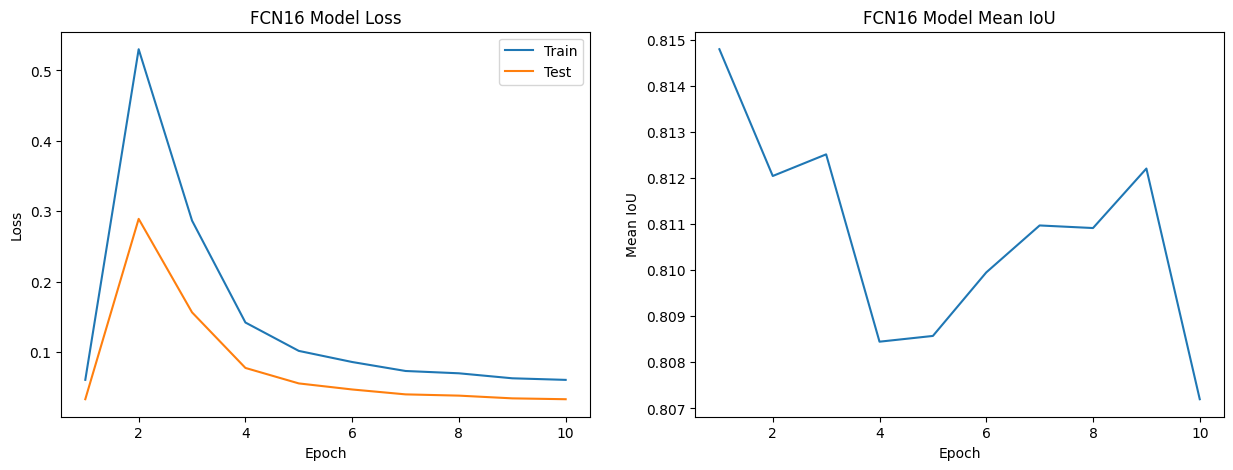

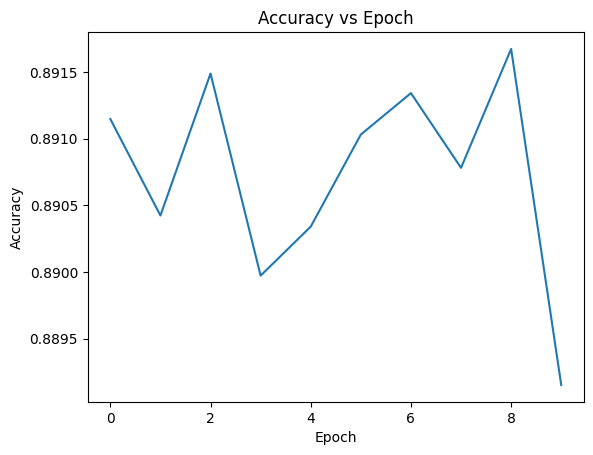

In [88]:
# Calculate the total training time
prog_end = time.time()
dura = prog_end - prog_start
print("Overall Time duration:", dura)

#Ploting the metrics
plotting_metric(model, num_epochs, train_data_loss, validation_losses, mean_inter, accuracy_values)

SDS Model

In [89]:
class SDS(nn.Module):
    def __init__(self, num_classes):
        super(SDS, self).__init__()

        # Load the pre-trained ResNet101 model and freeze its parameters
        resnet = models.resnet101(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad = False
            
        # Remove the fully connected layer and average pooling layer
        modules = list(resnet.children())[:-2]
        self.base = nn.Sequential(*modules)
        self.conv = nn.Conv2d(2048, 512, kernel_size=2, stride=1, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(512)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(p=0.5)
        self.score_fr = nn.Conv2d(512, num_classes, kernel_size=1)
        self.upscore = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=32, stride=16, bias=False)
        self._init_weights(num_classes)
        # Unfreeze the last two residual blocks of the base model
        for module in self.base[-1][-2:]:
            for param in module.parameters():
                param.requires_grad = True

    def forward(self, x):
        # Apply the base model
        x = self.base(x)
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.score_fr(x)
        x = self.upscore(x)
        return x

    def _init_weights(self, num_classes):
        # Initialize the weights of the deconvolutional layer to bilinear upsampling
        bi_linear = self._get_upsampling_weight(num_classes, num_classes, 32)
        self.upscore.weight.data.copy_(bi_linear)

    def _get_upsampling_weight(self, in_channels, out_channels, kernel_size):
        # Create a bilinear kernel for upsampling
        fac = (kernel_size + 1) // 2
        cen = kernel_size / 2
        multigrid = np.ogrid[:kernel_size, :kernel_size]
        bi_fil = (1 - abs(multigrid[0] - cen) / fac) * (1 - abs(multigrid[1] - cen) / fac)
        weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size), dtype=np.float32)
        weight[range(in_channels), range(out_channels), :, :] = bi_fil
        return torch.from_numpy(weight)

In [90]:
# Define the hyperparameters
learning_rate = 0.001
num_epochs = 10
batch_size = 16
num_classes = 32
# SDS Model intialization
model = SDS(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# Getting the Running losses for each epoch
r_losses = train(model, train_loader, optimizer, criterion, num_epochs)

Epoch [1/10], Loss: 1.737855851650238
Epoch [2/10], Loss: 0.5943866670131683
Epoch [3/10], Loss: 0.3963252951701482
Epoch [4/10], Loss: 0.34102076292037964
Epoch [5/10], Loss: 0.3074326018492381
Epoch [6/10], Loss: 0.28764428198337555
Epoch [7/10], Loss: 0.2737160821755727
Epoch [8/10], Loss: 0.2593409816424052
Epoch [9/10], Loss: 0.2515741189320882
Epoch [10/10], Loss: 0.2563932289679845


In [91]:
# Validation of the model to find the Evaluation metrics
Iou_fine, best_model, train_data_loss, validation_losses, mean_inter, accuracy_values, acc_fine = validate(model, val_loader, num_epochs, r_losses)

# Print the best IoU achieved on the validation dataset
print("Best IoU on val data on SDS Model:", Iou_fine)
# Print the Mean Pixel Accuracy achieved on the validation dataset
print(f"Pixel Accuracy on val data on SDS Model: {acc_fine:.4f}")

Best IoU on val data on SDS Model: 0.8120045595698886
Pixel Accuracy on val data on SDS Model: 0.8977


In [92]:
# Testing the models on the testing dataset
Iou_fine, best_model, train_data_loss, validation_losses, mean_inter, accuracy_values, acc_fine = validate(model, test_loader, num_epochs, r_losses)
model.load_state_dict(best_model)

with torch.no_grad():
    total_pixel_acc = 0.0
    overall_samples = 0
    for data in test_loader:
        inputs, labels = data
        outputs = model(inputs)
        outputs = F.interpolate(outputs, size=labels.shape[-2:], mode='bilinear', align_corners=True)
        predicted_labels = torch.argmax(outputs, dim=1)
        pixel_acc = Pixel_Accuracy(predicted_labels, labels)
        total_pixel_acc += pixel_acc * inputs.size(0)
        overall_samples += inputs.size(0)

    mean_pixel_acc = total_pixel_acc / overall_samples

# Print the best IoU achieved on the validation dataset
print("Best IoU for testing data on SDS Model:", Iou_fine)
# Print the Mean Pixel Accuracy achieved on the validation dataset
print(f"Mean Pixel Accuracy for testing data on SDS Model: {mean_pixel_acc:.4f}")

Best IoU for testing data on SDS Model: 0.8203691840171814
Mean Pixel Accuracy for testing data on SDS Model: 0.8945


Overall Time duration: 700.5939319133759


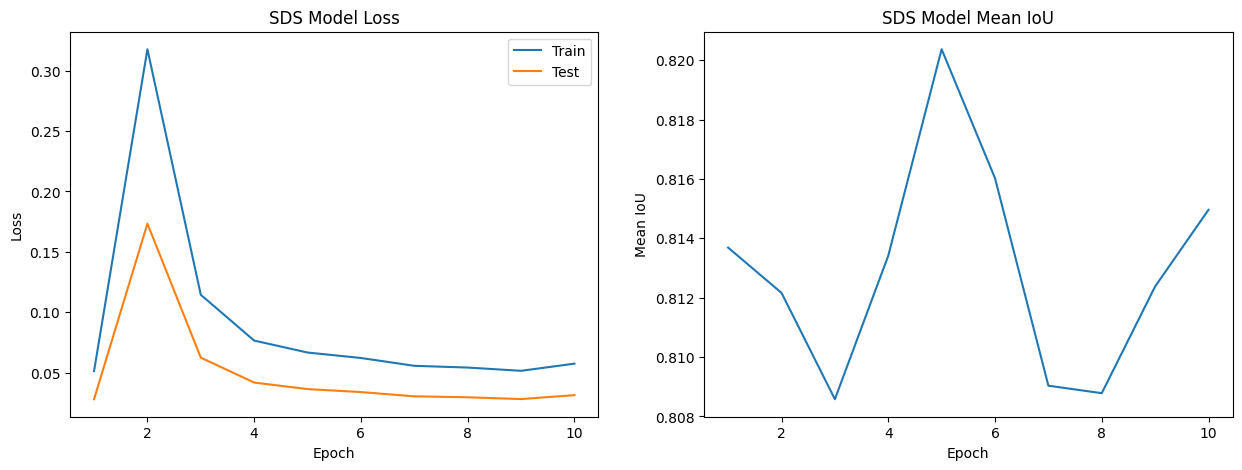

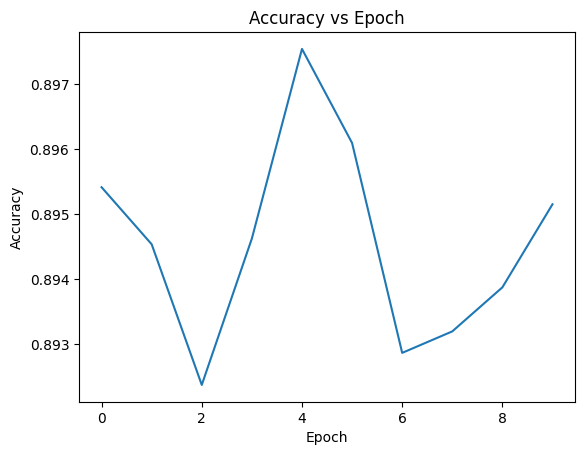

In [93]:
# Calculate the total training time
prog_end = time.time()
dura = prog_end - prog_start
print("Overall Time duration:", dura)

#Ploting the metrics
plotting_metric(model, num_epochs, train_data_loss, validation_losses, mean_inter, accuracy_values)

UNet Model

In [94]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True))

    def forward(self, x):
        x = self.conv(x)
        return x


class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNet, self).__init__()
        self.encoder_blocks = nn.ModuleList()
        self.decoder_blocks = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Encoder blocks
        for feature in features:
            self.encoder_blocks.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Decoder blocks
        for feature in reversed(features):
            self.decoder_blocks.append(
                nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2)
            )
            self.decoder_blocks.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        encoder_outputs = []
        # Encoder pass
        for encoder_block in self.encoder_blocks:
            x = encoder_block(x)
            encoder_outputs.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        
        # Decoder pass
        for idx in range(0, len(self.decoder_blocks), 2):
            decoder_block = self.decoder_blocks[idx]
            skip_connection = encoder_outputs[-(idx//2+1)]
            x = decoder_block(x, output_size=skip_connection.shape)
            x = torch.cat([skip_connection, x], dim=1)
            x = self.decoder_blocks[idx+1](x)

        x = self.final_conv(x)
        return x

In [95]:
# Define the hyperparameters
learning_rate = 0.001
num_epochs = 10
batch_size = 16
num_classes = 32

# Initialize the model
model = UNet(in_channels=3, out_channels=num_classes, features=[64, 128, 256, 512])

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#Get the Running losses for each epoch
r_losses = train(model, train_loader, optimizer, criterion, num_epochs)

Epoch [1/10], Loss: 2.488989313443502
Epoch [2/10], Loss: 1.7295232216517131
Epoch [3/10], Loss: 1.498694082101186
Epoch [4/10], Loss: 1.2366127769152324
Epoch [5/10], Loss: 1.0728085438410442
Epoch [6/10], Loss: 0.9137150049209595
Epoch [7/10], Loss: 0.8243390619754791
Epoch [8/10], Loss: 0.6822572747866312
Epoch [9/10], Loss: 0.5993163287639618
Epoch [10/10], Loss: 0.5249131719271342


In [96]:
# Validation of the model to find the Evaluation Metrics
Iou_fine, best_model, train_data_loss, validation_losses, mean_inter, accuracy_values, acc_fine = validate(model, val_loader, num_epochs, r_losses)

# Print the best IoU achieved on the validation dataset
print("Best IoU on val data on UNet Model:", Iou_fine)
# Print the Mean Pixel Accuracy achieved on the validation dataset
print(f"Best Pixel Accuracy val data on UNet Model: {acc_fine:.4f}")

Best IoU on val data on UNet Model: 0.7160113983684115
Best Pixel Accuracy val data on UNet Model: 0.8100


In [97]:
# Testing the models on the testing dataset
Iou_fine, best_model, train_data_loss, validation_losses, mean_inter, accuracy_values, acc_fine = validate(model, test_loader, num_epochs, r_losses)
model.load_state_dict(best_model)

with torch.no_grad():
    total_pixel_acc = 0.0
    overall_samples = 0
    for data in test_loader:
        inputs, labels = data
        outputs = model(inputs)
        outputs = F.interpolate(outputs, size=labels.shape[-2:], mode='bilinear', align_corners=True)
        predicted_labels = torch.argmax(outputs, dim=1)
        pixel_acc = Pixel_Accuracy(predicted_labels, labels)
        total_pixel_acc += pixel_acc * inputs.size(0)
        overall_samples += inputs.size(0)

    mean_pixel_acc = total_pixel_acc / overall_samples

# Print the best IoU achieved on the validation dataset
print("Best IoU for testing data on UNet Model:", Iou_fine)
# Print the Mean Pixel Accuracy achieved on the validation dataset
print(f"Mean Pixel Accuracy for testing data on UNet Model: {mean_pixel_acc:.4f}")

Best IoU for testing data on UNet Model: 0.7185059189796448
Mean Pixel Accuracy for testing data on UNet Model: 0.7990


Overall Time duration: 1889.9258089065552


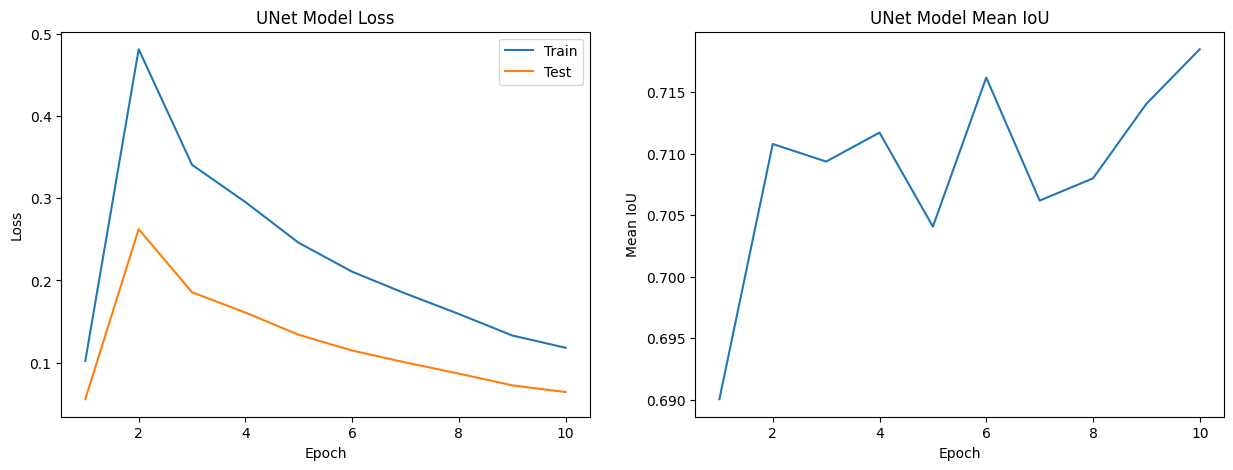

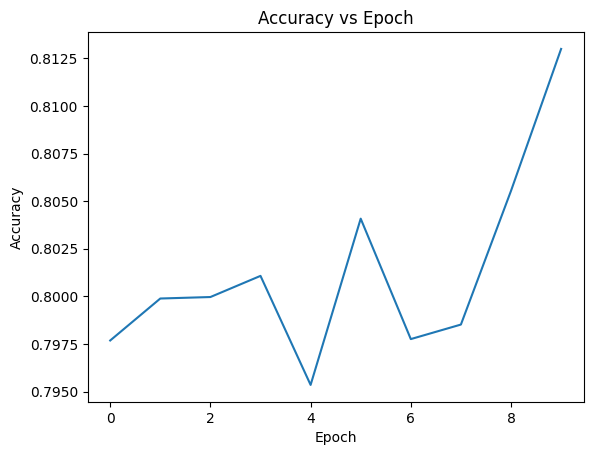

In [98]:
# Calculate the total training time
prog_end = time.time()
dura = prog_end - prog_start
print("Overall Time duration:", dura)

#Ploting the metrics
plotting_metric(model, num_epochs, train_data_loss, validation_losses, mean_inter, accuracy_values)